# CUSTOM GLM CLASS

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import chi2
import pandas as pd
import numpy as np


# ------------------------------
# Namespace-based Family Functions
# ------------------------------

def multinomial():
    return {
        'loss': lambda y_pred, y_true, weight=None: F.cross_entropy(y_pred, y_true, weight=weight),
        'predict_proba': lambda y_pred: F.softmax(y_pred, dim=1),
        'log_likelihood': lambda y_pred, y_true: torch.log(F.softmax(y_pred, dim=1).clamp(min=1e-9))[range(len(y_true)), y_true].sum()
    }

def binomial():
    return {
        'loss': lambda y_pred, y_true, weight=None: F.binary_cross_entropy_with_logits(y_pred.squeeze(), y_true.float(), weight=weight),
        'predict_proba': lambda y_pred: torch.sigmoid(y_pred),
        'log_likelihood': lambda y_pred, y_true: (y_true * torch.log(torch.sigmoid(y_pred).clamp(min=1e-9)) + (1 - y_true) * torch.log((1 - torch.sigmoid(y_pred)).clamp(min=1e-9))).sum()
    }

def gaussian():
    return {
        'loss': lambda y_pred, y_true, weight=None: F.mse_loss(y_pred.squeeze(), y_true.float()),
        'predict_proba': lambda y_pred: y_pred,
        'log_likelihood': lambda y_pred, y_true: -0.5 * ((y_true.float() - y_pred.squeeze()) ** 2).sum()
    }


# ------------------------------
# GLM Model Class
# ------------------------------
class GLM(nn.Module):
    def __init__(self, input_dim, output_dim=1, family=None, class_weights=None, feature_names = None):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.family = family
        self.class_weights = class_weights
        self.fitted = False
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.feature_names = feature_names

        if not isinstance(self.family, dict):
            raise ValueError("family must be a dict returned by binomial(), gaussian(), or multinomial()")

    def forward(self, X):
        return self.linear(X)

    def fit(self, X, y, lr=1e-2, epochs=100, verbose=False):
        self.train()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = self(X)
            loss = self.family['loss'](y_pred, y, weight=self.class_weights)
            loss.backward()
            optimizer.step()
            if verbose and epoch % 10 == 0:
                if self.output_dim > 1:
                    acc = (y_pred.argmax(dim=1) == y).float().mean().item()
                    print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Acc: {acc:.4f}")
                else:
                    print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")
        self.fitted = True

    def predict(self, X):
        if not self.fitted:
            raise ValueError("Model must be fit before prediction.")
        self.eval()
        with torch.no_grad():
            pred = self(X)
            if self.output_dim > 1:
                return pred.argmax(dim=1)
            else:
                return (self.family['predict_proba'](pred) > 0.5).long()

    def predict_proba(self, X):
        if not self.fitted:
            raise ValueError("Model must be fit before prediction.")
        self.eval()
        with torch.no_grad():
            return self.family['predict_proba'](self(X))

    def compute_deviance(self, X, y):
        y_pred = self(X)
        ll = self.family['log_likelihood'](y_pred, y)
        return -2 * ll.item()

    def summary(self, X, y, feature_names=None):
        if feature_names is None:
            feature_names = self.feature_names        
        deviance_full = self.compute_deviance(X, y)

        # Null model
        logits_null = torch.zeros(len(y), self.output_dim if self.output_dim > 1 else 1, requires_grad=True)
        optimizer = torch.optim.Adam([logits_null], lr=0.1)
        for _ in range(300):
            optimizer.zero_grad()
            loss = self.family['loss'](logits_null, y)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            ll_null = self.family['log_likelihood'](logits_null, y)
            deviance_null = -2 * ll_null.item()

        df_diff = self.input_dim
        lr_stat = deviance_null - deviance_full
        p_value = chi2.sf(lr_stat, df_diff)

        print("\nModel Summary:")
        print(f"{'Model':<20} {'Deviance':<12} {'Df':<6} {'LR Chi2':<10} {'Pr(>Chi2)':<10}")
        print(f"{'Null':<20} {deviance_null:<12.2f}")
        print(f"{'Full':<20} {deviance_full:<12.2f} {df_diff:<6} {lr_stat:<10.2f} {p_value:<10.4g}")

        if feature_names:
            print("\n Feature Significance Tests:")
            for i, name in enumerate(feature_names):
                X_reduced = torch.cat([X[:, :i], X[:, i + 1:]], dim=1)
                model_reduced = GLM(
                    input_dim=X_reduced.shape[1],
                    output_dim=self.output_dim,
                    family=self.family,
                    class_weights=self.class_weights
                )
                model_reduced.fit(X_reduced, y, epochs=100)
                deviance_reduced = model_reduced.compute_deviance(X_reduced, y)
                lr_feat = deviance_reduced - deviance_full
                p_feat = chi2.sf(lr_feat, 1)
                print(f"{name:<30} {deviance_reduced:<12.2f} {1:<6} {lr_feat:<10.2f} {p_feat:<10.4g}")

# ============================================
# glm() wrapper for easier, R-style syntax
# ============================================
# Update glm() wrapper to accept feature_names and pass it
def glm(X, y, family="gaussian", class_weights=None, fit=True, verbose=False, **fit_kwargs):
  

    # Infer feature names
    if hasattr(X, 'columns'):
        feature_names = list(X.columns)
        X_tensor = torch.tensor(X.values).float()
    elif isinstance(X, np.ndarray):
        feature_names = [f"X{i}" for i in range(X.shape[1])]
        X_tensor = torch.tensor(X).float()
    elif isinstance(X, torch.Tensor):
        feature_names = [f"X{i}" for i in range(X.shape[1])]
        X_tensor = X
    else:
        raise TypeError("X must be a pandas DataFrame, NumPy array, or PyTorch tensor.")

    family_lookup = {
        "binomial": binomial,
        "gaussian": gaussian,
        "multinomial": multinomial,
    }

    if family not in family_lookup:
        raise ValueError(f"Unsupported family '{family}'. Choose from {list(family_lookup)}")

    fam_instance = family_lookup[family]()
    input_dim = X_tensor.shape[1]

    if family == "multinomial":
        output_dim = int(y.max().item()) + 1 if y.ndim == 1 else y.shape[1]
    else:
        output_dim = 1

    model = GLM(
        input_dim=input_dim,
        output_dim=output_dim,
        family=fam_instance,
        class_weights=class_weights,
        feature_names=feature_names
    )

    if fit:
        model.fit(X_tensor, y, verbose=verbose, **fit_kwargs)

    return model



In [2]:
# Simulate data
X = torch.randn(200, 10)
feature_names = [f"feature_{i}" for i in range(X.shape[1])]

# ------------------------
# Multinomial GLM Summary
# ------------------------
print("\n=== Multinomial GLM Summary ===")
y_multi = torch.randint(0, 3, (200,))
model_multi = glm(X, y_multi, family="multinomial", verbose=False)
model_multi.summary(X, y_multi)

# ------------------------
# Binomial GLM Summary
# ------------------------
print("\n=== Binomial GLM Summary ===")
y_bin = torch.randint(0, 2, (200,))
model_bin = glm(X, y_bin, family="binomial", verbose=False)
model_bin.summary(X, y_bin)

# ------------------------
# Gaussian GLM Summary
# ------------------------
print("\n=== Gaussian GLM Summary ===")
y_gauss = torch.randn(200)
model_gauss = glm(X, y_gauss, family="gaussian", verbose=False)
model_gauss.summary(X, y_gauss)



=== Multinomial GLM Summary ===

Model Summary:
Model                Deviance     Df     LR Chi2    Pr(>Chi2) 
Null                 0.74        
Full                 419.01       10     -418.27    1         

 Feature Significance Tests:
X0                             424.82       1      5.81       0.01589   
X1                             421.74       1      2.73       0.09822   
X2                             422.32       1      3.31       0.06867   
X3                             419.65       1      0.64       0.4245    
X4                             420.31       1      1.30       0.2544    
X5                             419.10       1      0.09       0.762     
X6                             421.62       1      2.61       0.1065    
X7                             421.47       1      2.46       0.1171    
X8                             419.20       1      0.19       0.6595    
X9                             419.48       1      0.47       0.4931    

=== Binomial GLM Summary ===



# CUSTOM NO TEARS

## BASE CLASS

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib

# Safe font settings to avoid glyph/emoji issues
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

class NoTearsDAGLearner:
    def __init__(self, input_dim, device="cpu"):
        self.input_dim = input_dim
        self.device = device
        self.model = self._build_model().to(device)
        self.W_learned = None

    def _build_model(self):
        class NoTearsNet(nn.Module):
            def __init__(self, d):
                super().__init__()
                self.W = nn.Parameter(torch.zeros(d, d))

            def forward(self, X):
                return X @ self.W

        return NoTearsNet(self.input_dim)

    def _dag_constraint(self, W):
        return torch.trace(torch.matrix_exp(W * W)) - W.shape[0]

    def fit(self, X, lambda1=0.01, rho=1.0, alpha=0.0,
            max_iter=10, max_inner_iter=20, lr=0.01,
            h_tol=1e-8, loss_tol=1e-5, patience=5, verbose=True):

        X = X.to(self.device)
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        best_loss = float("inf")
        best_W = None
        wait = 0

        for outer_iter in range(max_iter):
            if verbose:
                print(f" Run {outer_iter + 1}/{max_iter}")

            for inner_iter in range(max_inner_iter):
                optimizer.zero_grad()
                X_hat = self.model(X)
                loss_recon = ((X - X_hat) ** 2).mean()
                h = self._dag_constraint(self.model.W)
                penalty = 0.5 * rho * h ** 2 + alpha * h
                l1 = lambda1 * torch.norm(self.model.W, p=1)
                loss = loss_recon + penalty + l1
                loss.backward()
                optimizer.step()

            current_loss = loss.item()
            h_val = h.item()

            if verbose:
                print(f"   End of run {outer_iter + 1}: Loss={current_loss:.4f}, h(W)={h_val:.2e}")

            if h_val <= h_tol:
                if verbose:
                    print(f"✅ DAG constraint satisfied at run {outer_iter + 1}")
                self.W_learned = self.model.W.detach().cpu()
                return self.W_learned

            if abs(current_loss - best_loss) < loss_tol:
                wait += 1
                if wait >= patience:
                    if verbose:
                        print(f"🛑 Early stopping at run {outer_iter + 1} due to loss stagnation.")
                    self.W_learned = best_W if best_W is not None else self.model.W.detach().cpu()
                    return self.W_learned
            else:
                best_loss = current_loss
                best_W = self.model.W.detach().clone()
                wait = 0

            rho *= 10
            alpha += rho * h_val

        if verbose:
            print("⚠️ Max iterations reached without satisfying DAG or early stopping.")

        self.W_learned = best_W if best_W is not None else self.model.W.detach().cpu()
        return self.W_learned

    def get_adjacency_matrix(self, threshold=0.01, top_k=None):
        if self.W_learned is None:
            raise ValueError("Must call `fit()` first.")

        W = self.W_learned.clone()
        mask = torch.abs(W) >= threshold

        if top_k is not None and top_k > 0:
            abs_weights = torch.abs(W)
            flattened = abs_weights.flatten()
            if flattened.numel() > top_k:
                topk_vals, _ = torch.topk(flattened, top_k)
                cutoff = topk_vals[-1]
                mask = abs_weights >= cutoff

        W = W * mask.float()
        return W

    def plot_graph(self, feature_names=None, threshold=0.01, top_k=None, figsize=(12, 10)):
        if self.W_learned is None:
            raise ValueError("Must call `fit()` before plotting.")

        A = self.get_adjacency_matrix(threshold=threshold, top_k=top_k).numpy()

        if feature_names is None:
            feature_names = [f"X{i}" for i in range(A.shape[0])]
        else:
            feature_names = [
                str(name).encode("ascii", "ignore").decode("ascii")[:30].replace("\n", " ")
                for name in feature_names
            ]

        G = nx.DiGraph()
        edge_count = 0
        for i, src in enumerate(feature_names):
            for j, tgt in enumerate(feature_names):
                weight = A[i, j]
                if abs(weight) > 0:
                    G.add_edge(src, tgt, weight=round(weight, 3))
                    edge_count += 1

        print(f"🔹 Number of edges after thresholding: {edge_count}")

        pos = nx.spring_layout(G, seed=42)
        edge_labels = nx.get_edge_attributes(G, 'weight')

        plt.figure(figsize=figsize)
        nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=2500, font_size=10, arrows=True)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
        plt.title(f"Learned DAG (NoTears)\nthresh={threshold}, top_k={top_k}")
        plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)
        plt.show()


## EXAMPLE RUN

[0.0] Loss=1.0000 h(W)=0.00e+00
[0.10] Loss=0.9465 h(W)=1.24e-01
[0.20] Loss=0.9191 h(W)=1.85e-01
[0.30] Loss=0.9071 h(W)=1.24e-01
[0.40] Loss=0.8993 h(W)=1.33e-01
[0.50] Loss=0.8970 h(W)=1.46e-01
[0.60] Loss=0.8958 h(W)=1.35e-01
[0.70] Loss=0.8934 h(W)=1.40e-01
[0.80] Loss=0.8924 h(W)=1.41e-01
[0.90] Loss=0.8931 h(W)=1.38e-01
[1.0] Loss=1.1789 h(W)=1.40e-01
[1.10] Loss=0.9712 h(W)=8.64e-03
[1.20] Loss=0.9346 h(W)=8.17e-03
[1.30] Loss=0.9339 h(W)=1.17e-02
[1.40] Loss=0.9293 h(W)=2.93e-03
[1.50] Loss=0.9294 h(W)=3.25e-03
[1.60] Loss=0.9278 h(W)=3.87e-03
[1.70] Loss=0.9292 h(W)=3.23e-03
[1.80] Loss=0.9277 h(W)=2.65e-03
[1.90] Loss=0.9275 h(W)=2.86e-03
[2.0] Loss=0.9277 h(W)=2.87e-03
[2.10] Loss=0.9265 h(W)=1.58e-03
[2.20] Loss=0.9262 h(W)=1.92e-03
[2.30] Loss=0.9258 h(W)=1.87e-03
[2.40] Loss=0.9260 h(W)=1.75e-03
[2.50] Loss=0.9265 h(W)=1.80e-03
[2.60] Loss=0.9262 h(W)=1.92e-03
[2.70] Loss=0.9276 h(W)=1.77e-03
[2.80] Loss=0.9271 h(W)=1.86e-03
[2.90] Loss=0.9259 h(W)=1.80e-03
[3.0] Loss=0.

/tmp/ipykernel_5533/1722310072.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/zsarkar01/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


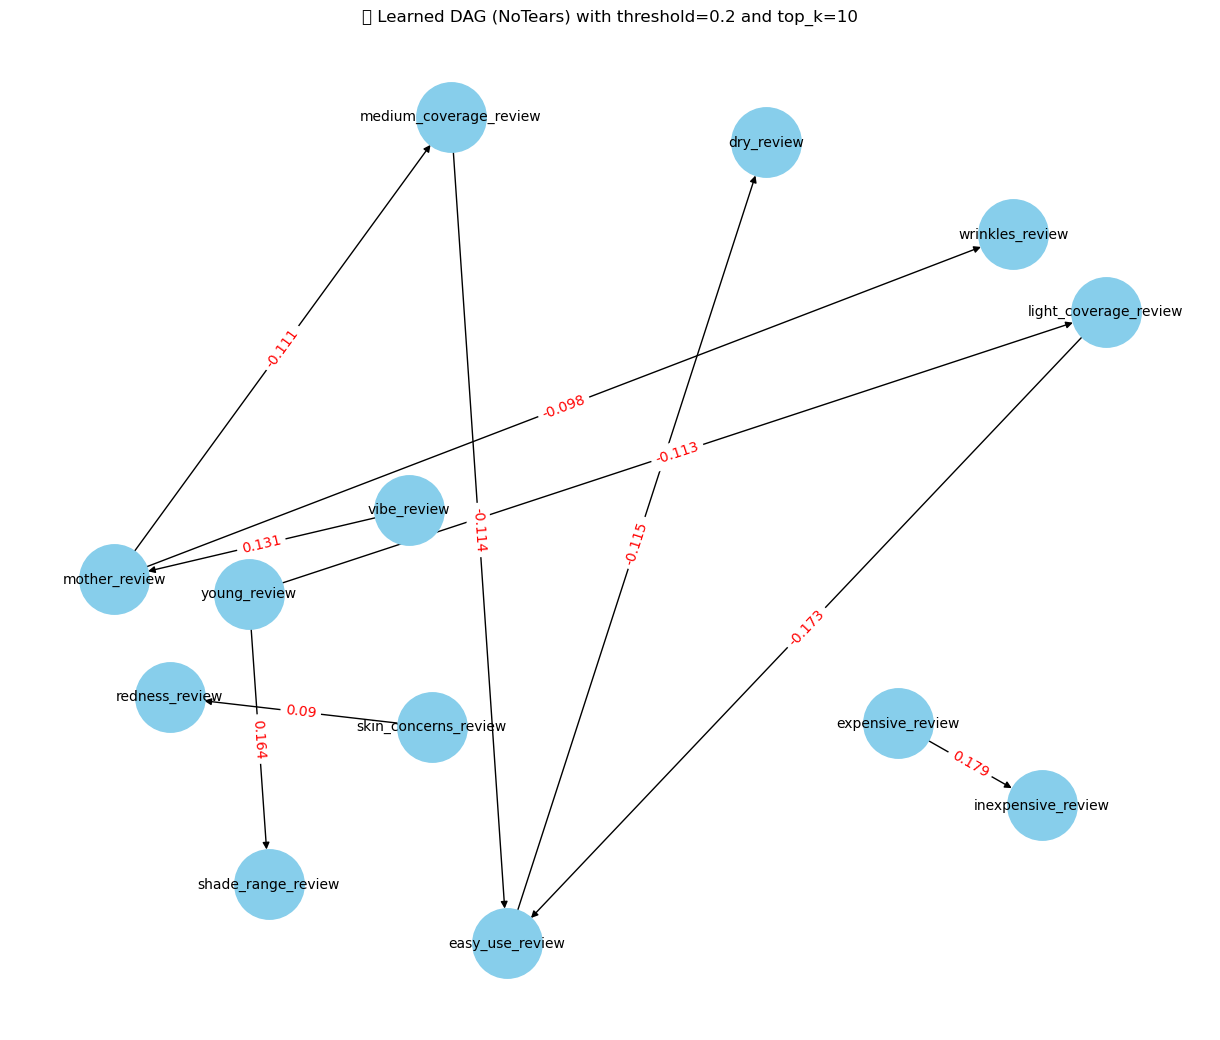

In [6]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Load data
path = '../Makeup_Recommender/reddit_training_data.csv'
df = pd.read_csv(path)
df = df[df["category"] == "Foundation"]
feature_cols = [
    'young_review', 'mother_review', 'professional_review', 'vibe_review', 'acne_review', 'dry_review',
    'wrinkles_review', 'black_review', 'white_review', 'tan_review', 'redness_review',
    'light_coverage_review', 'medium_coverage_review', 'full_coverage_review',
    'expensive_review', 'inexpensive_review', 'skin_concerns_review', 'comfortable_wear_review',
    'easy_use_review', 'pilling_review', 'shade_range_review'
]

# Preprocess
df = df.dropna(subset=feature_cols)
X = df[feature_cols].values
X = StandardScaler().fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32)

# Train DAG learner with Lasso penalty
learner = NoTearsDAGLearner(input_dim=X.shape[1])
learner.fit(X_tensor, lambda1=0.05, max_iter=40, verbose=True)

# Plot DAG with threshold and keep only top 10 edges
learner.plot_graph(feature_names=feature_cols, threshold=0.20, top_k=10)


## ONE HOT ENCODING FOR NOTEARS

In [ ]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

'''
extract the word set first from headline and comments
use nltk

'''

# Load & merge
df_products = pd.read_csv('../Makeup_Recommender/cleaned_makeup_products.csv', usecols=['product_link_id', 'category'])
df_reviews = pd.read_csv('../Makeup_Recommender/cleaned_makeup_reviews.csv', low_memory=False)
df = pd.merge(df_reviews, df_products, how='inner', on='product_link_id')
df = df[df["category"] == "Foundation"]

print(df_reviews.columns)
# Drop irrelevant cols
exclude_cols = [
    "unique_review_id", "product_link_id", "review_id", "ugc_id", "legacy_id",
    "locale", "location",
    "internal_review_id", "uri", "nickname", "created_date", 
    "updated_date", "type", "id", "product_page_id", "gtin", "upc"
]
meta_cols = [col for col in df.columns if col not in exclude_cols]
df_meta = df[meta_cols].copy()

# Optional: drop extremely sparse columns (e.g. >95% missing)
missing_ratio = df_meta.isna().mean()
sparse_cols = missing_ratio[missing_ratio > 0.95].index.tolist()
df_meta = df_meta.drop(columns=sparse_cols)

# Impute missing values
num_cols = df_meta.select_dtypes(include="number").columns
obj_cols = df_meta.select_dtypes(include="object").columns

df_meta[num_cols] = df_meta[num_cols].fillna(df_meta[num_cols].median())
df_meta[obj_cols] = df_meta[obj_cols].fillna("unknown")

# Map t/f to 1/0 for boolean-like columns
bool_like = ["is_verified_buyer", "is_verified_reviewer", "is_staff_reviewer"]
for col in bool_like:
    if col in df_meta.columns and df_meta[col].dtype == object:
        df_meta[col] = df_meta[col].map({'t': 1, 'f': 0}).fillna(0).astype(int)

# One-hot encode object/categorical columns
cat_cols = df_meta.select_dtypes(include="object").columns.tolist()
print(cat_cols)
df_meta_encoded = pd.get_dummies(df_meta, columns=cat_cols)

# Drop zero-variance columns
df_meta_encoded = df_meta_encoded.loc[:, (df_meta_encoded != 0).any(axis=0)]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_meta_encoded)

# Convert to tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

print("✅ Final tensor shape:", X_tensor.shape)


Index(['unique_review_id', 'product_link_id', 'review_id', 'type', 'id',
       'ugc_id', 'legacy_id', 'internal_review_id', 'headline', 'nickname',
       'created_date', 'updated_date', 'rating', 'helpful_votes',
       'not_helpful_votes', 'uri', 'comments', 'locale', 'location',
       'bottom_line', 'product_page_id', 'upc', 'gtin', 'is_staff_reviewer',
       'is_verified_buyer', 'is_verified_reviewer', 'helpful_score'],
      dtype='object')
['headline', 'comments', 'category']


In [2]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Load only required columns
df_reviews = pd.read_csv('../Makeup_Recommender/cleaned_makeup_reviews.csv', usecols=['headline', 'comments'], low_memory=False)
df_products = pd.read_csv('../Makeup_Recommender/cleaned_makeup_products.csv', usecols=['product_link_id', 'category'])

# Combine and clean text rows into list of strings
text_rows = list(zip(
    df_reviews['headline'].fillna(''),
    df_reviews['comments'].fillna('')
))

# Build vocabulary efficiently
vocab = set()
for headline, comment in text_rows:
    combined = f"{headline} {comment}"
    tokens = word_tokenize(combined.lower())
    tokens = [w for w in tokens if w.isalpha() and w not in stop_words]
    vocab.update(tokens)

print(f"Unique word count (excluding stopwords): {len(vocab)}")
vocab = sorted(vocab)
print(vocab)


[nltk_data] Downloading package punkt to /home/zsarkar01/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/zsarkar01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Unique word count (excluding stopwords): 15659
['aa', 'aaa', 'aaaaaamazing', 'aaaahhhh', 'aaaamazing', 'aaalll', 'aaamazing', 'aaked', 'aand', 'aay', 'ab', 'aback', 'abandon', 'abd', 'abfull', 'abh', 'abide', 'abilities', 'ability', 'abit', 'abity', 'able', 'abnormal', 'aboid', 'abomination', 'aborbs', 'aboslutely', 'aboutface', 'abrasive', 'abroad', 'absolue', 'absolufe', 'absolulely', 'absoluletly', 'absolulty', 'absolurely', 'absolute', 'absolutelty', 'absolutelu', 'absolutely', 'absolutlely', 'absolutley', 'absolutly', 'absolutoy', 'absoluyely', 'absorb', 'absorbed', 'absorbent', 'absorber', 'absorbing', 'absorbs', 'absorption', 'absoulety', 'absoulte', 'absoulutly', 'absurd', 'absurdly', 'abt', 'abuse', 'abusing', 'abusive', 'abysmal', 'ac', 'acabado', 'acc', 'accent', 'accented', 'accents', 'accentuate', 'accentuated', 'accentuates', 'accentuating', 'accept', 'acceptable', 'accepted', 'accepting', 'access', 'accessibility', 'accessible', 'accessing', 'accident', 'accidentally', '

In [23]:
df_meta = df[meta_cols].copy()
print("Shape before dropna:", df_meta.shape)
print("Number of NA values per column:\n", df_meta.isna().sum())
df_meta = df_meta.dropna()
print("Shape after dropna:", df_meta.shape)

Shape before dropna: (59974, 9)
Number of NA values per column:
 rating                      0
helpful_votes               0
not_helpful_votes           0
bottom_line             57101
is_staff_reviewer           0
is_verified_buyer           0
is_verified_reviewer        0
helpful_score               0
category                    0
dtype: int64
Shape after dropna: (2873, 9)


 Run 1/10
   End of run 1: Loss=0.6070, h(W)=1.98e-01
 Run 2/10
   End of run 2: Loss=0.7539, h(W)=1.54e-02
 Run 3/10
   End of run 3: Loss=0.7769, h(W)=3.38e-03
 Run 4/10
   End of run 4: Loss=0.7874, h(W)=1.44e-03
 Run 5/10
   End of run 5: Loss=0.7992, h(W)=3.40e-04
 Run 6/10
   End of run 6: Loss=0.8013, h(W)=8.92e-05
 Run 7/10
   End of run 7: Loss=0.8042, h(W)=2.15e-05
 Run 8/10
   End of run 8: Loss=0.8035, h(W)=3.81e-06
 Run 9/10
   End of run 9: Loss=10.3283, h(W)=4.28e-04
 Run 10/10
   End of run 10: Loss=18.3991, h(W)=3.91e-05
⚠️ Max iterations reached without satisfying DAG or early stopping.
🔹 Number of edges after thresholding: 20


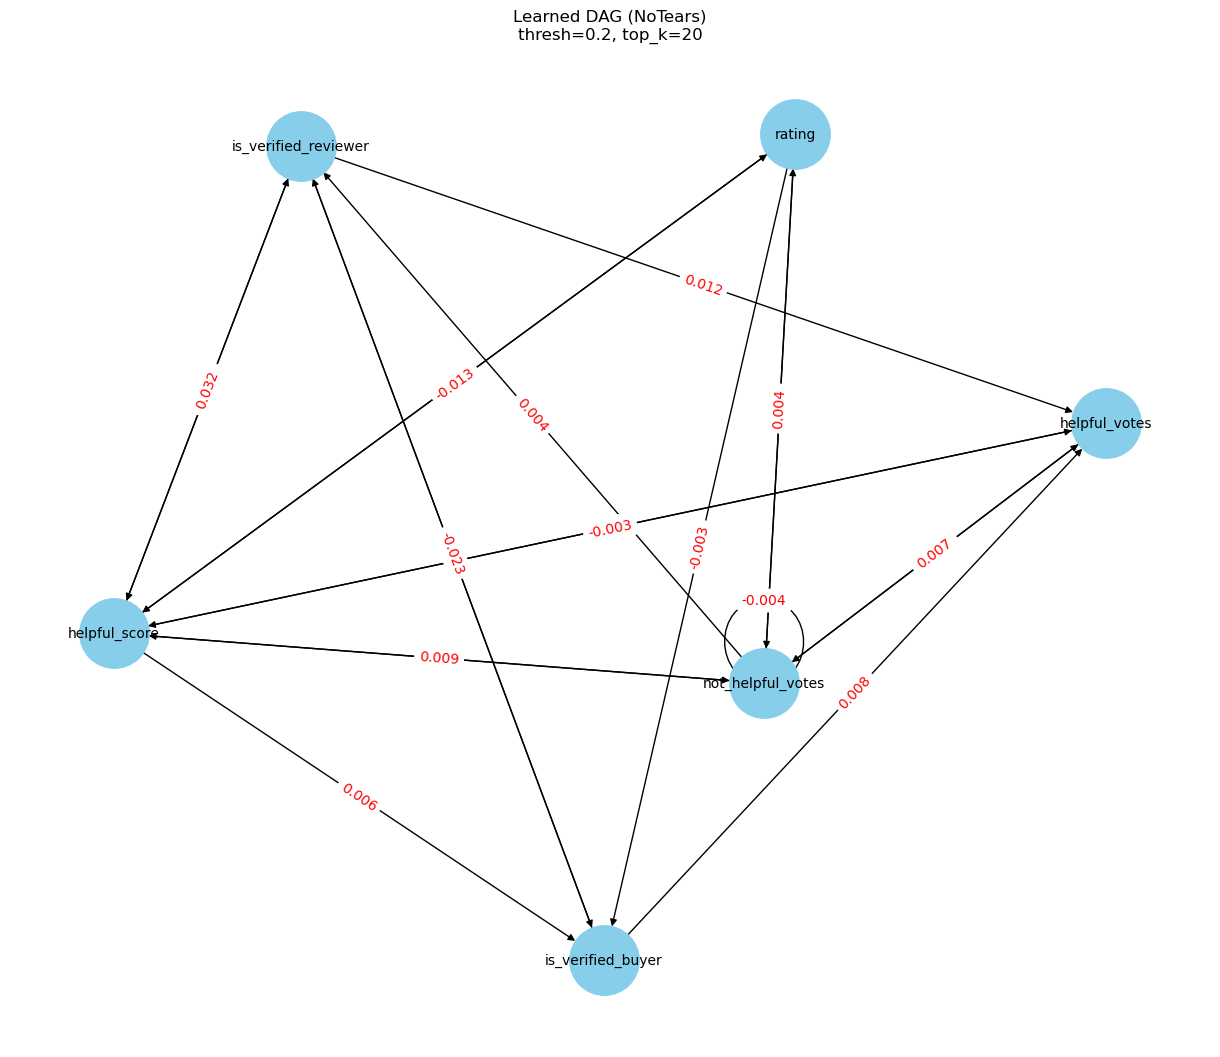

In [22]:
learner = NoTearsDAGLearner(input_dim=X_tensor.shape[1])
learner.fit(X_tensor, lambda1=0.05, max_iter=5, verbose=True)
learner.plot_graph(
    feature_names=df_meta_encoded.columns.tolist(),
    threshold=0.2,
    top_k=10
)
